/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/plotting/html_stat_map.py:198: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



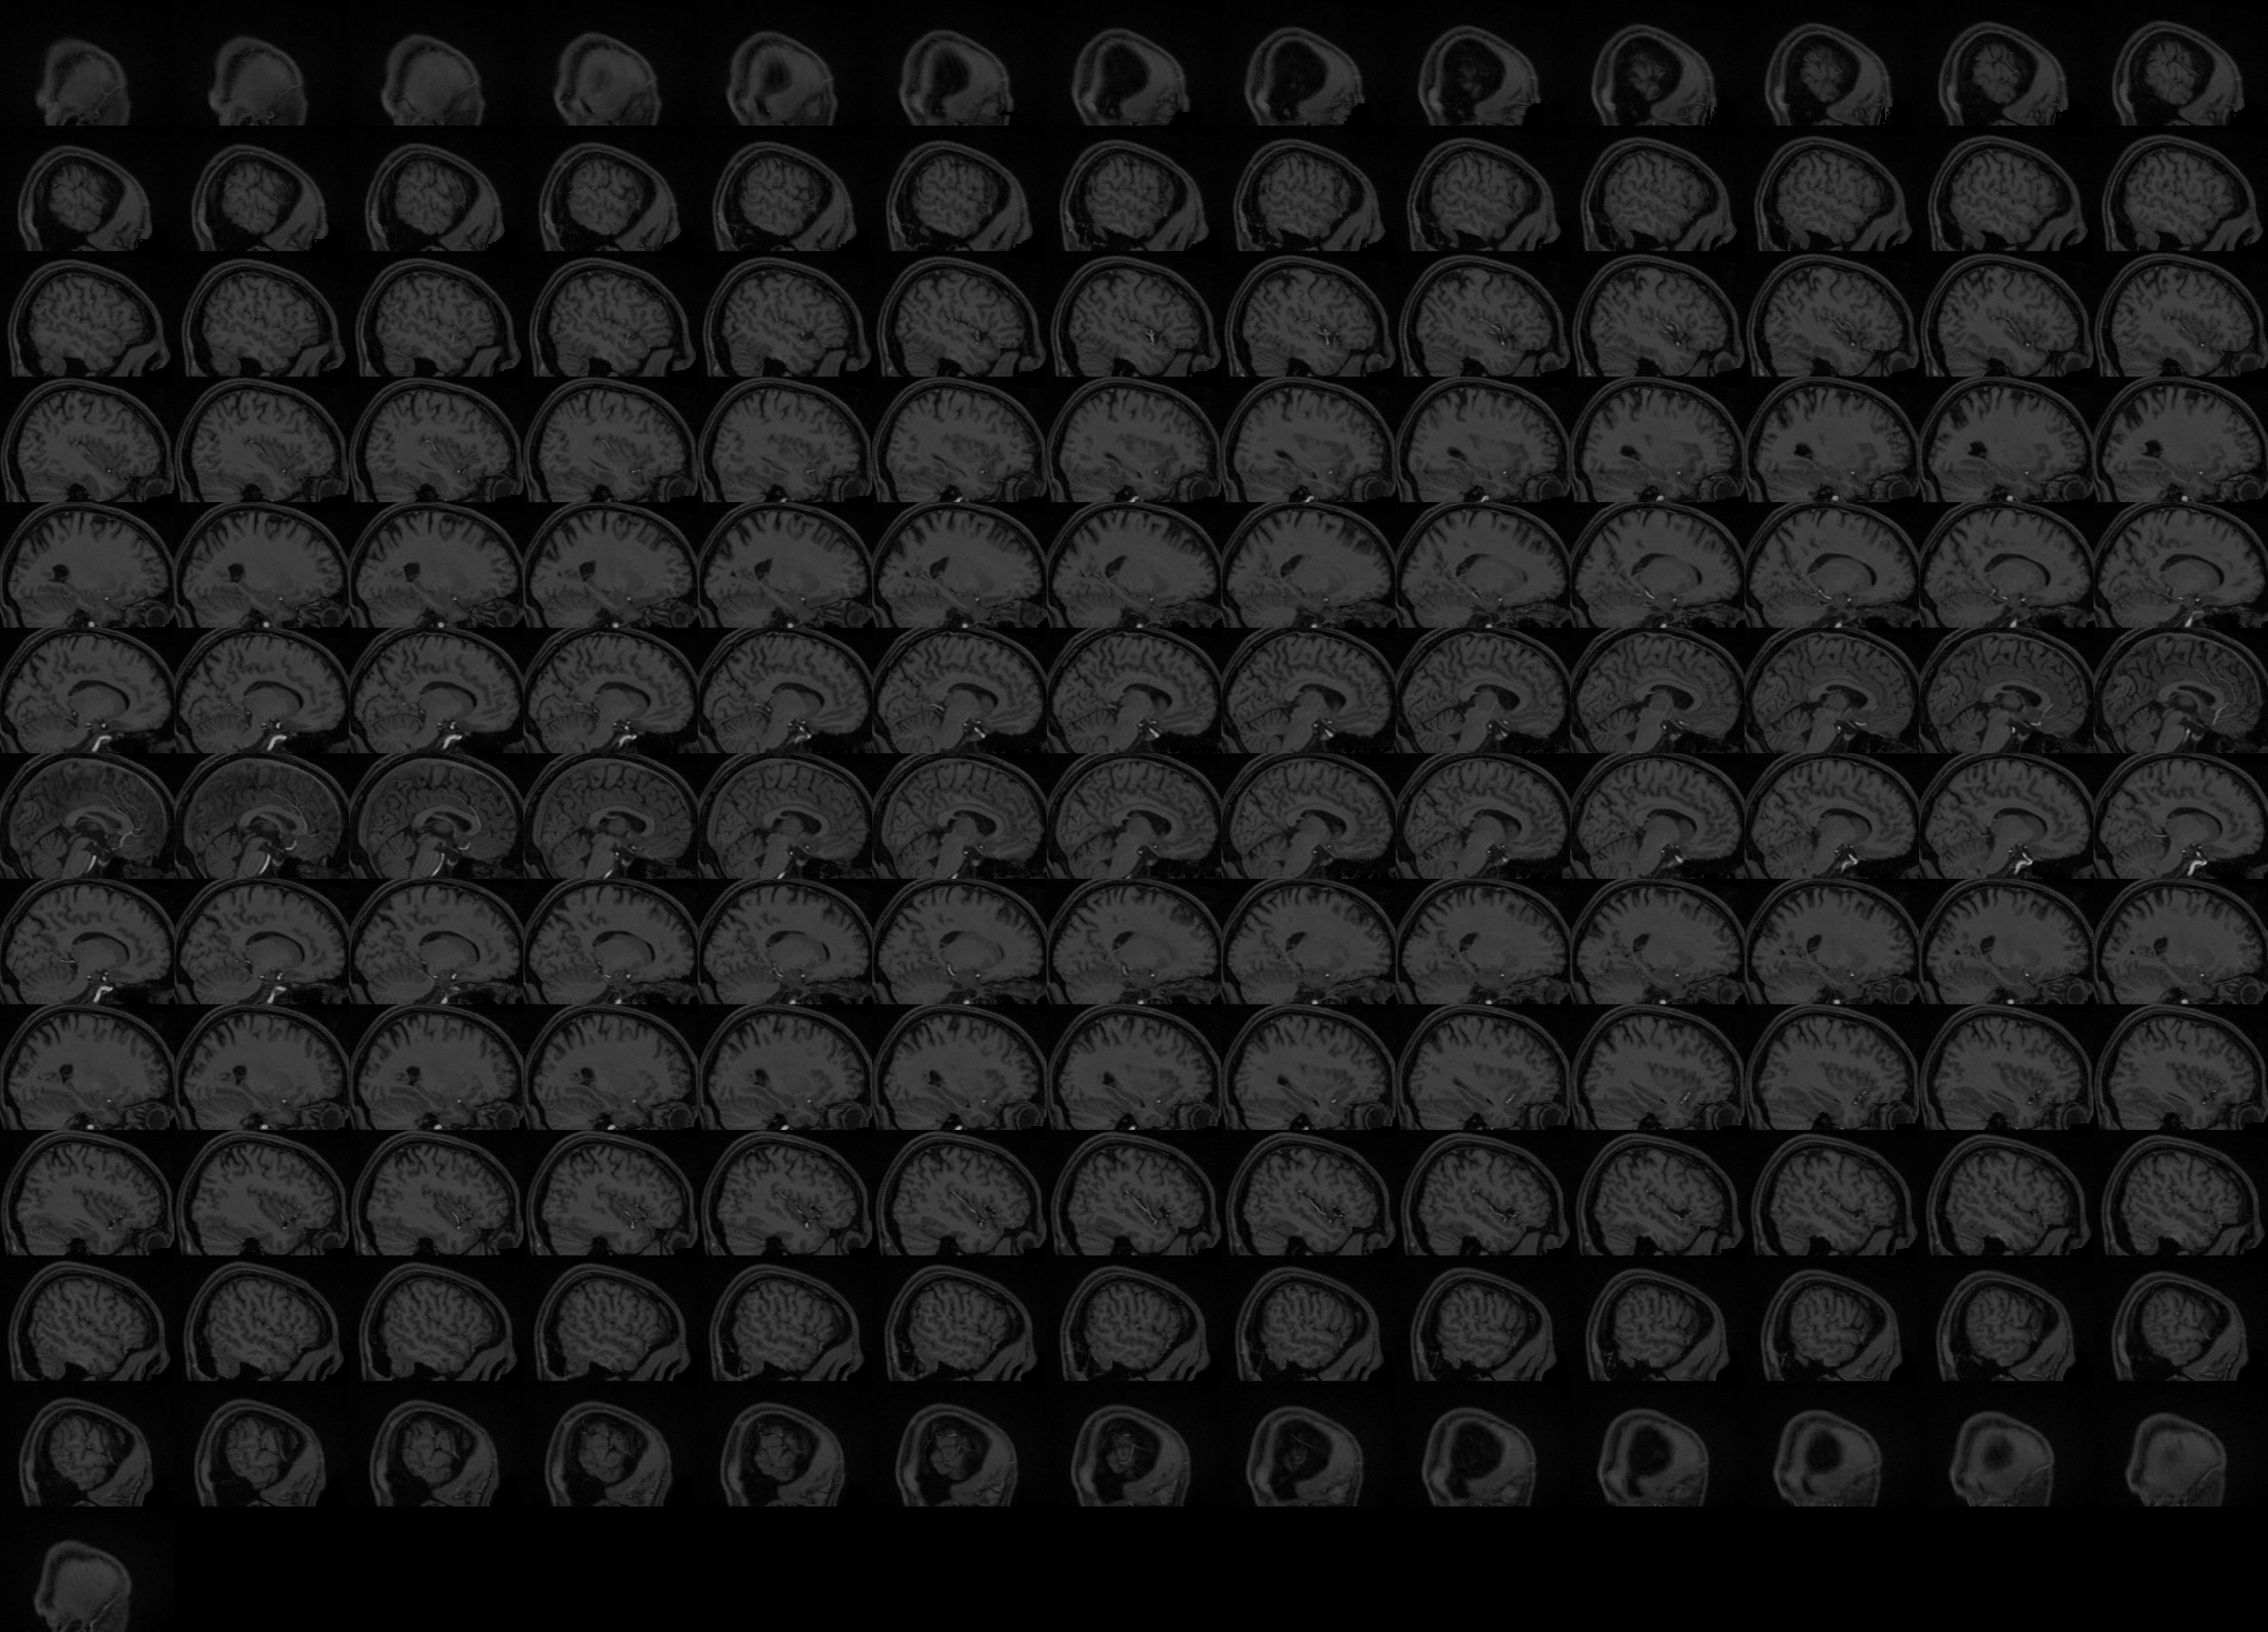
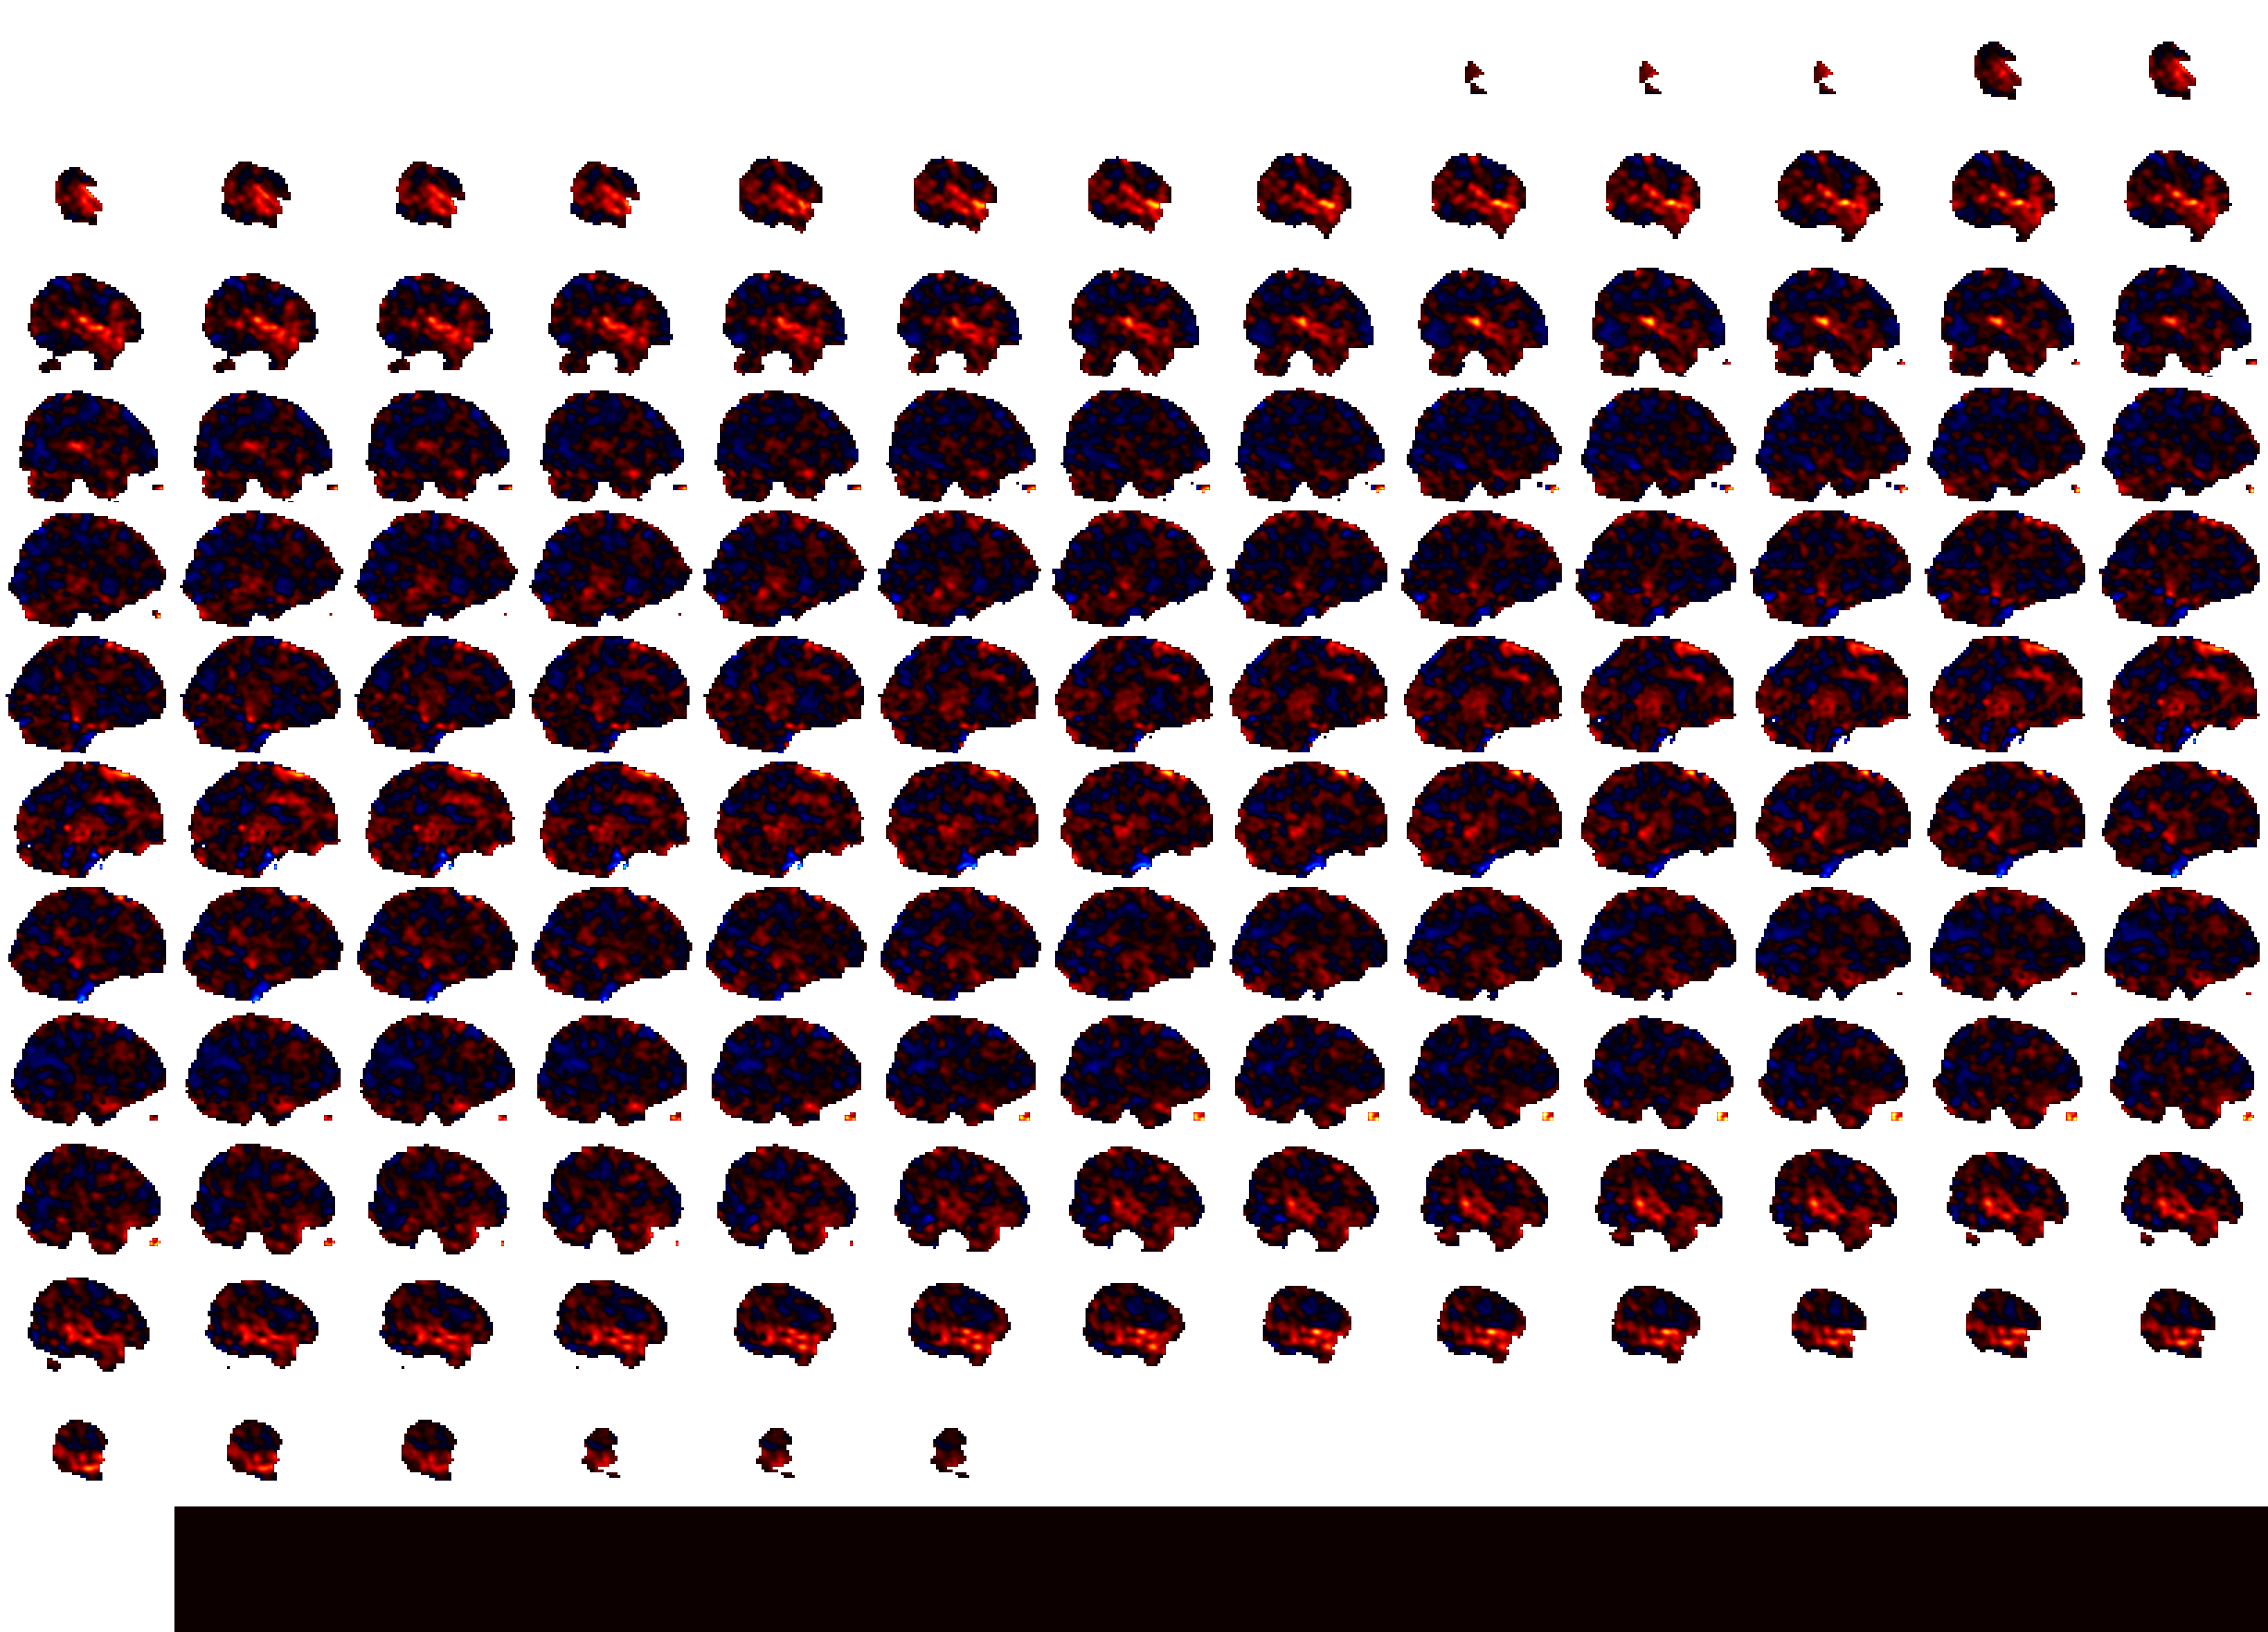

In [6]:
# %%
"""
================================================================
Low-resolution surface alignment of 2 individuals with fMRI data
================================================================

In this example, we align 2 low-resolution left hemispheres
using 4 fMRI feature maps (z-score contrast maps).
"""
# sphinx_gallery_thumbnail_number = 6
import gdist
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from fugw.mappings import FUGW
from fugw.utils import load_mapping, save_mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nilearn import datasets, image, plotting, surface

# %%
# Let's download 5 volumetric contrast maps per individual
# using ``nilearn``'s API. We will use the first 4 of them
# to compute an alignment between the source and target subjects,
# and use the left-out contrast to assess the quality of our alignment.

n_subjects = 2

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
n_training_contrasts = 4

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

# %%
# Here is what the first contrast map of the source subject looks like
# (the following figure is interactive):

contrast_index = 1
plotting.view_img(
    source_imgs_paths[contrast_index],
    brain_data["anats"][0],
    title=f"Contrast {contrast_index} (source subject)",
    opacity=1,
)

In [7]:

fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage3")

# %%


def load_images_and_project_to_surface(image_paths):
    """Util function for loading and projecting volumetric images."""
    images = [image.load_img(img) for img in image_paths]
    surface_images = [
        np.nan_to_num(surface.vol_to_surf(img, fsaverage3.pial_left))
        for img in images
    ]

    return np.stack(surface_images)


source_features = load_images_and_project_to_surface(source_imgs_paths)
target_features = load_images_and_project_to_surface(target_imgs_paths)
source_features.shape




/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/ni

(5, 642)

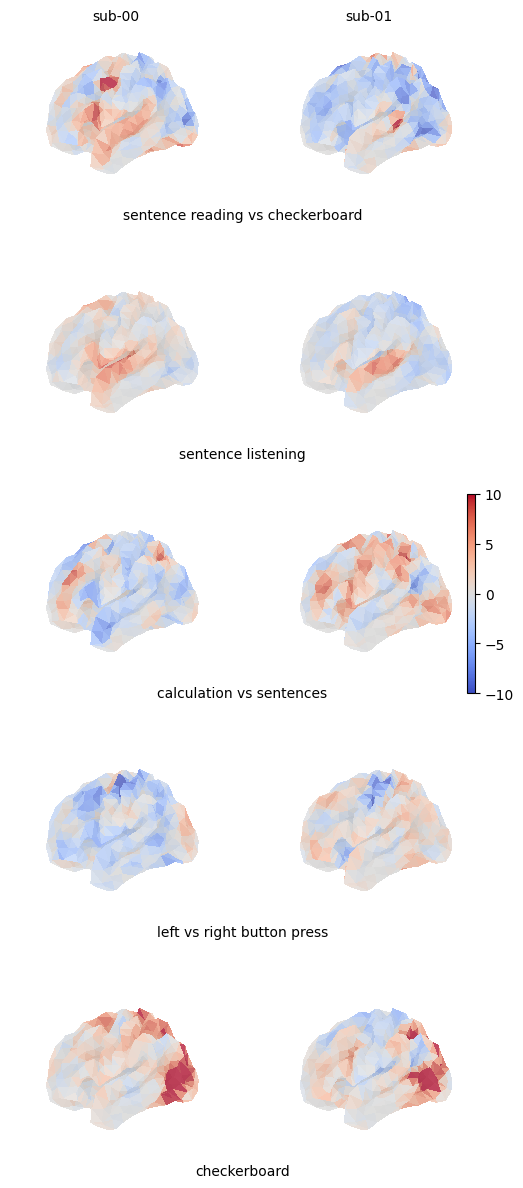

In [8]:
# %%
# Here is a figure showing the 4 projected maps for each of
# the 2 individuals:


def plot_surface_map(surface_map, cmap="coolwarm", colorbar=True, **kwargs):
    """Util function for plotting surfaces."""
    plotting.plot_surf(
        fsaverage3.pial_left,
        surface_map,
        cmap=cmap,
        colorbar=colorbar,
        bg_map=fsaverage3.sulc_left,
        bg_on_data=True,
        darkness=0.5,
        **kwargs,
    )


fig = plt.figure(figsize=(3 * n_subjects, 3 * len(contrasts)))
grid_spec = gridspec.GridSpec(len(contrasts), n_subjects, figure=fig)

# Print all feature maps
for i, contrast_name in enumerate(contrasts):
    for j, features in enumerate([source_features, target_features]):
        ax = fig.add_subplot(grid_spec[i, j], projection="3d")
        plot_surface_map(
            features[i, :], axes=ax, vmax=10, vmin=-10, colorbar=False
        )

    # Add labels to subplots
    if i == 0:
        for j in range(2):
            ax = fig.add_subplot(grid_spec[i, j])
            ax.axis("off")
            ax.text(0.5, 1, f"sub-0{j}", va="center", ha="center")

    ax = fig.add_subplot(grid_spec[i, :])
    ax.axis("off")
    ax.text(0.5, 0, contrast_name, va="center", ha="center")

# Add colorbar
ax = fig.add_subplot(grid_spec[2, :])
ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%")
fig.add_axes(cax)
fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=-10, vmax=10), cmap="coolwarm"
    ),
    cax=cax,
)

plt.show()